In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

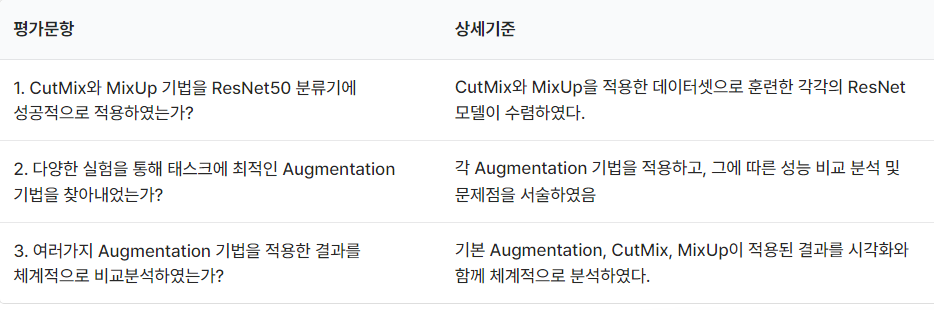

다음의 평가문항을 참고한다

CutMix와 MixUp기법을 ResNet50 분류기에 적용하자

Augmentation 여러가지 기법을 실험해 최적인 기법을 찾자 - 성능 비교분석, 문제점 서술

Augmentation 비교분석 - 시각화

일단 이 모든 작업을 수행하기에 앞서 어떤 순서로 진행할지 생각해야 한다

1) 데이터 불러오기

2) Augmentation 적용하기

3) Augmentation 각 기법에 대해서 비교하기

4) CutMix MixUp 데이터셋에 적용하기 -> 각각의 ResNet 모델로 fit 

5) Aug, CutMix, MixUp이 적용된 결과 시각화

#  1. 데이터 불러오기!

stanford_dogs 데이터셋을 사용한다.

In [3]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)
print("데이터 다운로드 완료")

데이터 다운로드 완료


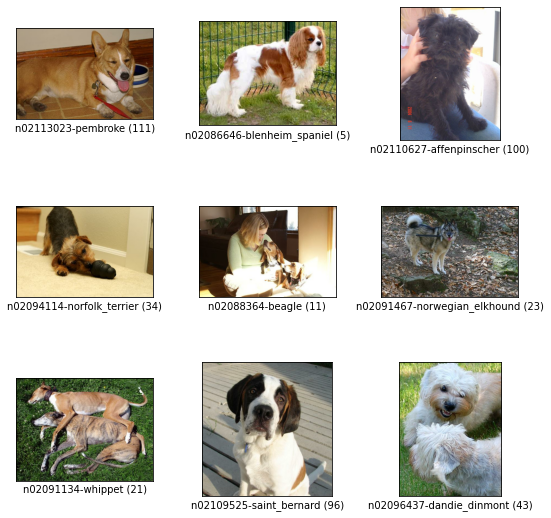

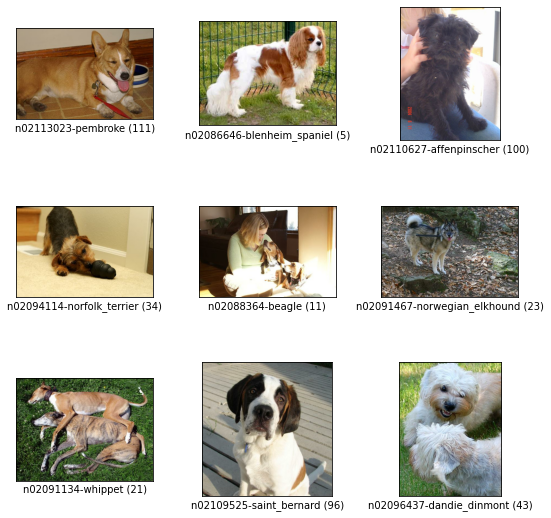

In [4]:
tfds.show_examples(ds_train,ds_info)

# 2. Augmentation 적용하기

Augmentation을 적용하기위해선 이미지들의 사이즈를 동일하게 맞춰줘야 한다

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: 'uint8'->'float32'
    image = tf.image.resize(image,[224,224])
    return tf.cast(image, tf.float32) / 255., label
    

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image,max_delta=0.2)
    image = tf.clip_by_value(image,0,1) #min max clipping --> min 0 max 1
    return image, label


    

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img, #기본적인 전처리 함수 적용한다
        num_parallel_calls=2, 
    )
    
    if not is_test and with_aug:  #train이 aug가 적용되지 않았다면 augment적용
        ds = ds.map(
            augment,
            num_parallel_calls=2,
        )
    ds = ds.batch(batch_size) #16 default
    if not is_test: # train이라면 데이터셋 반복 , ds.shuffle 통해 다시 섞어준다.
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 3. Augmentation 비교실험

Imagenet으로 훈련된 Resnet50모델을 불러올 것이다.

include_top을 False를 해서, 마지막 FC를 제외하고 feature extract부분만 불러와서 우리의 데이터셋에 맞는 FC를 붙인다

그렇다면 훈련은 되고, 우리 테스트셋에 맞게 적용 가능하다

먼저 Aug를 적용시킨 데이터셋과 Aug를 적용하지 않은 데이터셋을 나눠야 하므로 2개를 만들어준다

In [8]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet', #feature extract
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])



120


In [9]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet', #feature extract
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])


In [10]:
(ds_train,ds_test),ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test1 = apply_normalize_on_dataset(ds_test, is_test=True)



resnet50과 aug_resnet50에 각각 ds_train_no_aug, ds_train_aug 데이터들 넣어 학습시킨다

In [11]:
resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

EPOCH=20

In [12]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), # batchsize로 나눔
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test1,
    verbose=1,
    use_multiprocessing=True,
    
)

Epoch 1/20
750/750 [==============================] - 164s 204ms/step - loss: 2.2109 - accuracy: 0.4477 - val_loss: 3.4430 - val_accuracy: 0.1950
Epoch 2/20
750/750 [==============================] - 167s 223ms/step - loss: 0.6862 - accuracy: 0.8142 - val_loss: 1.1075 - val_accuracy: 0.6788
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.2163 - accuracy: 0.9565 - val_loss: 0.9464 - val_accuracy: 0.7207
Epoch 4/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0641 - accuracy: 0.9946 - val_loss: 0.9274 - val_accuracy: 0.7312
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0295 - accuracy: 0.9987 - val_loss: 0.9294 - val_accuracy: 0.7383
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0193 - accuracy: 0.9990 - val_loss: 0.9547 - val_accuracy: 0.7350
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0166 - accuracy: 0.9994 - val_loss: 0.9735 -

In [13]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test1,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 2.2841 - accuracy: 0.4270 - val_loss: 3.2360 - val_accuracy: 0.2276
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.9661 - accuracy: 0.7209 - val_loss: 1.2600 - val_accuracy: 0.6330
Epoch 3/20
750/750 [==============================] - 152s 202ms/step - loss: 0.5257 - accuracy: 0.8552 - val_loss: 1.0282 - val_accuracy: 0.7025
Epoch 4/20
750/750 [==============================] - 152s 202ms/step - loss: 0.2870 - accuracy: 0.9301 - val_loss: 1.0314 - val_accuracy: 0.7015
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 0.1534 - accuracy: 0.9697 - val_loss: 1.0383 - val_accuracy: 0.7119
Epoch 6/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0957 - accuracy: 0.9831 - val_loss: 1.0712 - val_accuracy: 0.7028
Epoch 7/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0608 - accuracy: 0.9911 - val_loss: 0.9765 -

훈련과정을 비교를 위해 시각화해보자

plt.plot(history_resnet50_no_aug.history['val_accuracy'],'r')
plt.plot(history_resnet50_aug.history['val_accuracy'],'b')

plt.title('Model validation Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend('No Augmentation','With Augmentation', loc='upper left')

plt.show()

ylim을 통해 확대 + grid를 통해 격자 잘보이게함

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.show()

Epoch 3밖에 안돌려서 다음의 결과가 나왔는데 통상적으로 With Aug가 더 높다

# 4 CutMix MixUp

이제 CutMix를 적용해볼 것이다

이미지 섞기 - 특정 바운딩박스를 뽑아 그부분에 대해서 이미지 2개를 섞어준다

In [14]:
#import matplotlib.pyplot as plt

#for i , (image, label) in enumerate(ds_train_no_aug.take(1)):
#    if i == 0:
#        image_a = image[0]
#        image_b = image[1]
#        label_a = label[0]
#        label_b = label[1]
#        break
#plt.subplot(1,2,1)
#plt.imshow(image_a)
#
#plt.subplot(1,2,2)
#plt.imshow(image_b)

#plt.show()


In [15]:
#image_a.shape

In [16]:
def get_clip_box(image_a, image_b):
    #이미지 resize를 먼저 공통적으로 해준다.
    
    #(height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    
    #get the center of box # uniform -> (shape, minval, maxval)
    x = tf.cast(tf.random.uniform([],0,image_size_x),tf.int32)
    y = tf.cast(tf.random.uniform([],0,image_size_y),tf.int32)
    
    #get the width, height of the box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    #clip box in image and get minmax bbox
    x_min = tf.math.maximum(0,x-width//2)
    y_min = tf.math.maximum(0,y-height//2)
    
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min,y_min,x_max,y_max


    

In [17]:
#x_min,y_min,x_max,y_max = get_clip_box(image_a,image_b)

#print('x : ' , x_min, x_max)
#print('y : ' , y_min, y_max)

x는 14부터 182, y는 0부터 97 바운딩박스를 구했다

In [18]:
#mix two images  a는 영역밖, b는 영역내 이미지 가져와서 합친다

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    middle_left = image_a[y_min:y_max , 0:x_min, :] # image_b의 왼쪽바깥영역이다.
    middle_center = image_b[y_min:y_max, x_min:x_max , :] #image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max , x_max:image_size_x, :] #image_b의 오른쪽바깥영역
    
    middle = tf.concat([middle_left, middle_center, middle_right],axis=1)
    top = image_a[0:y_min, : , :]
    bottom = image_a[y_max:image_size_y, : , : ]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img




    

In [19]:
#mixed_img = mix_2_images(image_a, image_b, x_min,y_min,x_max,y_max)
#plt.imshow(mixed_img)
#plt.show()

이미지를 섞었으므로 label 또한 섞어줘야한다
CutMix에서는 면적에 비례해서 라벨을 섞어줍니다.

In [20]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    mixed_area = (y_max-y_min)*(x_max-x_min)
    total_area = image_size_y * image_size_x
    ratio = tf.cast(mixed_area / total_area, tf.float32)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label



In [21]:
#mixed_label = mix_2_labels(image_a, image_b, x_min, y_min, x_max, y_max)
#mixed_label

# mix_2_images와 mix_2_label 활용해 배치단위 cutmix()함수 구현

In [22]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs=[]
    mixed_labels=[]
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        j = tf.cast(tf.random.uniform([],0,batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        x_min,y_min,x_max,y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min,y_min,x_max,y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a,label_b, x_min,y_min,x_max,y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size,3 ))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


    

In [23]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0: #라벨이 없으면 one_hot으로 만들라는 말 같다
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label



    
    

In [24]:
#mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
#plt.imshow(mixed_img.numpy())
#plt.show()
#print(mixed_label)

 각 label 퍼센트만큼 그림이 속했다고 보면 될 것 같다

# mixup_2_images를 통해 배치단위 mixup()함수 구현

In [25]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a,label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

이제 여태까지 만든 Augmentation 기법들을 한번에 사용가능하게 하는 def를 만든다

In [26]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label): # 여기에 augmentation 더 적용 가능
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug: # train, aug일때 
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # train, cutmix일 때 
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: # train, mixup일때
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else: #test일 때
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [27]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet', #feature extract
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])


In [28]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet', #feature extract
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])


In [29]:
#데이터셋 load를 한번만 하고 그걸 토대로 돌려야 같은 데이터를 기반으로 돌아갈텐데 너무 안일했다.
#(ds_train,ds_test),ds_info = tfds.load(
#    'stanford_dogs',
#    split=['train','test'],
#    as_supervised=True,
#    shuffle_files=True,
#    with_info=True,
#)
#ds_train_no_aug = apply_normalize_on_dataset(ds_train)
#ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test2 = apply_normalize_on_dataset(ds_test, is_test=True)
ds_train_cutmix= apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup=apply_normalize_on_dataset(ds_train, with_mixup=True)


In [30]:
ds_train_mixup

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

# 모델 compile

In [31]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [32]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

모델 훈련하기 no_aug와 aug는 참고를 위해 아래에 남겨놓고 위에서 훈련하기때문에 실행하지않는다.

# 모델 fit

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), # batchsize로 나눔
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [33]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), # batchsize로 나눔
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test2,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 205ms/step - loss: 3.8029 - accuracy: 0.2184 - val_loss: 3.5983 - val_accuracy: 0.1683
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9193 - accuracy: 0.4420 - val_loss: 1.4512 - val_accuracy: 0.5967
Epoch 3/20
750/750 [==============================] - 153s 203ms/step - loss: 2.6233 - accuracy: 0.5338 - val_loss: 1.3050 - val_accuracy: 0.6446
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.4017 - accuracy: 0.6116 - val_loss: 1.3103 - val_accuracy: 0.6304
Epoch 5/20
750/750 [==============================] - 153s 203ms/step - loss: 2.2488 - accuracy: 0.6602 - val_loss: 1.2359 - val_accuracy: 0.6620
Epoch 6/20
750/750 [==============================] - 168s 224ms/step - loss: 2.1232 - accuracy: 0.6990 - val_loss: 1.2055 - val_accuracy: 0.6707
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0414 - accuracy: 0.7252 - val_loss: 1.2619 -

In [34]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), # batchsize로 나눔
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test2,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 160s 205ms/step - loss: 3.7545 - accuracy: 0.2349 - val_loss: 4.4737 - val_accuracy: 0.0880
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 2.8417 - accuracy: 0.4888 - val_loss: 1.5294 - val_accuracy: 0.5708
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 2.5883 - accuracy: 0.5777 - val_loss: 1.5216 - val_accuracy: 0.5858
Epoch 4/20
750/750 [==============================] - 153s 203ms/step - loss: 2.3880 - accuracy: 0.6511 - val_loss: 1.2450 - val_accuracy: 0.6562
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 2.2729 - accuracy: 0.7016 - val_loss: 1.2204 - val_accuracy: 0.6655
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1661 - accuracy: 0.7428 - val_loss: 1.3015 - val_accuracy: 0.6461
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 2.0776 - accuracy: 0.7735 - val_loss: 1.3307 -

# 4개 모델에 대한 시각화

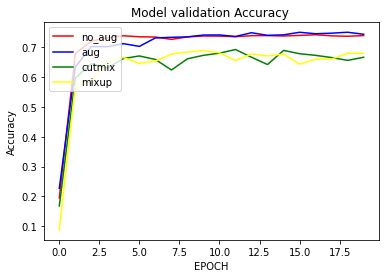

In [41]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'],'r')
plt.plot(history_resnet50_aug.history['val_accuracy'],'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'],'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'],color='yellow')


plt.title('Model validation Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend(['no_aug','aug','cutmix','mixup'], loc='upper left')
plt.show()

In [36]:
# mix_2_labels에서 받는 image_a값이 전역변수였어서 오류가 발생했었다. 이를 수정하느라 빡셋다.

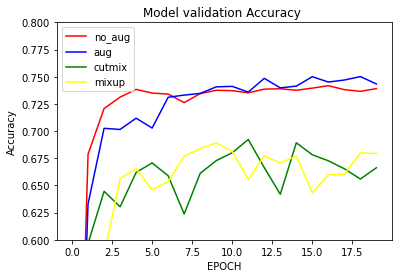

In [40]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'],'r')
plt.plot(history_resnet50_aug.history['val_accuracy'],'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'],'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'],color='yellow')


plt.title('Model validation Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.ylim(0.6,0.8)
plt.legend(['no_aug','aug','cutmix','mixup'], loc='upper left')
plt.show()

다음의 결과로 aug가 제일높고 그다음 no_aug,  mixup, cutmix의 순서로 나왔는데 본문과는 다르게 결과가 나와서 학습이 잘못 된듯 하다